## Captando água de um canal: um modelo baseado em agentes usando Python

Este é um modelo hidrológico onde os usuários de água retiram água de um canal. O objetivo deste notebook é contribuir para o campo da sociohidrologia e inspirar outros estudos utilizando a abordagem baseada em agentes. Usamos o pacote [Project Mesa](https://github.com/projectmesa/mesa/wiki/Mesa-Packages) para construir nosso modelo.

Mesa é uma biblioteca em Python para modelagem baseada em agentes. Ela possui classes base para construir as principais funcionalidades de um ABM.

### Setup

Se você não tiver o Mesa instalado, siga a [documentação](https://mesa.readthedocs.io/en/stable/). Também recomendo o uso do [Anaconda](https://www.anaconda.com/) para gerenciamento de pacotes.

Resumidamente, crie um novo ambiente virtual no anaconda e ative-o.

```
#Anaconda
conda activate mesaenv
#Terminal
source bin/activate
```

Em seguida, instale os três pacotes python que usaremos aqui: mesa, matplotlib e jupyter (para executar este notebook).

```
python3 -m pip install mesa
python3 -m pip install matplotlib
python3 -m pip install jupyter
```

### Classes Agent e Model

Vamos começar simples. Criamos duas classes, uma que representa os usuários que retiram água do canal, e outra que lida com variáveis a nível global do modelo. Eles são representados pelas classes `WaterUserAgent` e `WaterModel`. Aqui, `WaterUserAgent` possui apenas um atributo que corresponde à quantidade de água que determinado agente irá retirar do canal. Por enquanto, vamos definir o estado inicial desta variável para todos os agentes iguais a 1. A quantidade e unidade de medida da retirada de água por hora não é importante. Então por hora definiremos apenas que o usuário pode retirar 1 unidade de água do canal (seja ela m³/s, m³/h ou qualquer outra). É importante apenas que as unidades de medida do modelo sejam compatíveis na hora de realizar cálculos. Falaremos mais sobre isso daqui a pouco.

O WaterModel corresponde ao ambiente. Portanto, o modelo contém os múltiplos agentes criados. Por enquanto, o WaterModule possui apenas uma entrada, o número de agentes a serem criados na inicialização.

In [1]:
from mesa import Agent, Model

class WaterUserAgent(Agent):
    """An agent that interacts with the water canal by withdrawing water for he/she own use."""
    _last_id = 0
    
    def __init__(self, model):
        super().__init__(WaterUserAgent._last_id+1, model)
        WaterUserAgent._last_id += 1
        self.water_to_withdraw = 1

class WaterModel(Model):
    """
    Create a new Irrigation model with the given parameters.
        
    Args:
        N: int number that represent the number of water users to create per year
    """

    
    def __init__(self, N=10):
        self.num_agents = N
        # Create agents
        for i in range(self.num_agents):
            w = WaterUserAgent(self)


In [2]:
model = WaterModel(N=10)

### Definindo o espaço

Como todo canal hídrico, as interações entre os agentes e o canal afetarão os usuários a jusante. Por exemplo, no caso extremo em que o primeiro agente retira toda a água disponível do canal, todos os demais agentes não terão água para retirar. Usaremos o NetworkGrid que é uma forma baseada em grafos para definir o espaço. Desta forma, onde quer que um agente se aloque, iremos acompanhar os agentes próximos. Vamos precisar de ajuda da NetworkX, uma biblioteca em Python que cria grafos. Como estamos modelando um canal, um gráfico linear é suficiente. Veja que bacias hidrográficas inteiras podem ser modeladas alterando o grafo!

Vamos construir nosso grafo linear.

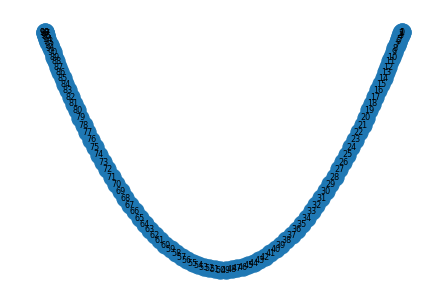

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.path_graph(100)
nx.draw_spectral(G, with_labels=True, font_size=8)

O gráfico não está bonito, mas funciona perfeitamente. Nós criamos um grafo com 100 nós. Um agente pode se alocar em um nó. Assim que esse nó é ocupado, não é possível que ele seja ocupado por 2 ou mais agentes. Logo, o número de nós restringe o número máximo de usuários no modelo. Como temos um pequeno canal com poucos usuários de água, 100 está bom. 

Assim que nosso gráfico linear estiver pronto, vamos atualizar a classe `WaterModel`! Criaremos também uma função que aloca usuários de água em um nó aleatório.

In [4]:
from mesa.space import NetworkGrid
import random

class WaterModel(Model):
    """
    Create a new Irrigation model with the given parameters.
        
    Args:
        N: int number that represent the number of water users to create per year
        G: generated linear graph using networkx
    """

    def __init__(self, N=2):
        self.num_agents = N
        self.grid = NetworkGrid(G)
        self.number_of_farmers_to_create = 10
        # Create agents
        for i in range(self.num_agents):
            w = WaterUserAgent(self)
            
    def create_farmers_random_position(self):
        """Create water users at random position in a linear graph."""
        while (i < self.number_of_farmers_to_create):
            random_node = random.sample(list(G.nodes()), 1)
            if (len(self.grid.get_cell_list_contents(random_node)) == 0):
                f = WaterUserAgent(self)
                self.schedule.add(f)
                self.grid.place_agent(f, random_node[0])
                i += 1
                
    def step(self):
        """ Execute the step for all agents, one at a time. At the end, advance model by one step """
        # Preparation
        self.create_farmers_random_position()
        
        # Run step
        self.schedule.step()

### Reordenando a ativação dos agentes (Schedule Personalizado)

Veja que na função step nós criamos os usuários de água e os alocamos em uma posição aleatória. Então, nós chamamos step no schedule. Isso executará a função step de todos os agentes, um por vez. Se você olhar para onde criamos a classe `WaterUserAgent`, ainda não definimos step para usuários de água. A cada iteração do modelo, os steps dos agentes serão executados. A ação que queremos que os agentes executem em cada iteração é retirar água do canal. Por padrão, o scheduler ativa os agentes aleatoriamente. Mas num canal hídrico, não é assim que deve funcionar. Usuários a montante afetarão os a jusante quanto à disponibilidade de água. Portanto, devemos redefinir a ordem em que os agentes são ativados (agentes mais a montante são ativados primeiro). Esta ordem é definida pelo Scheduler do mesa. Para redefinir a ordem em que os agentes com base em sua posição no canal, devemos criar um Scheduler personalizado.

Vamos colocar a criação da função step em espera e trabalhar no Scheduler.

Primeiro, criaremos um scheduler personalizado que herda a classe `BaseSchedule`, que é o scheduler mais simples que ativa os agentes um por vez e assume que todos eles têm um método step. Em seguida, criaremos um método que obtenha a ordem correta para ativar os agentes, classificando todos os agentes com base em sua posição. Por fim, criamos um método step que reordena a ativação dos agentes.

Mesa usa um Dicionário Ordenado (Ordered Dictionary), que é uma subclasse de dicionário em Python que lembra a ordem em que os itens foram adicionados adicionando uma chave a cada dicionário.

Caso você tenha vários tipos de agentes, você também pode redefinir a ordem em que cada classe de agente é ativada. Verifique [esta issue](https://github.com/projectmesa/mesa/issues/491) para mais detalhes.

In [5]:
from mesa.time import BaseScheduler
from collections import OrderedDict

class CanalScheduler(BaseScheduler):
    def __init__(self, model):
        super().__init__(model)
    
    def sort_agents(self):
        sorted_list_of_agents = sorted(self.agents, key=lambda x: x.pos)
        new_queue = OrderedDict(dict((i,j) for i,j in enumerate(sorted_list_of_agents)))
        return new_queue
        
    def step(self):
        self._agents = self.sort_agents()
        super().step()

Agora que temos nosso scheduler personalizado, finalmente criaremos o método `run_model` que chama o método step do nosso scheduler. Para testar, vamos criar o método step para que cada agente imprima uma mensagem quando for acionado para verificar se nossa implementação está correta.

In [1]:
class WaterUserAgent(Agent):
    """An agent that interacts with the water canal by withdrawing water for he/she own use."""
    _last_id = 0
    
    def __init__(self, model):
        super().__init__(WaterUserAgent._last_id+1, model)
        WaterUserAgent._last_id += 1
        self.water_to_withdraw = 1
    
    def step(self):
        print("Olá, Eu sou o Water Agent nº {} e estou na posição {}.".format(
            self.unique_id, self.pos))

class WaterModel(Model):
    """
    Create a new Irrigation model with the given parameters.
        
    Args:
        N: int number that represent the number of water users to create per year
        G: generated linear graph using networkx
    """

    def __init__(self, N=2):
        self.num_agents = N
        self.grid = NetworkGrid(G)
        self.number_of_farmers_to_create = 2
        
        # Define scheduler
        self.schedule = CanalScheduler(
            WaterModel)
        
        # Create agents
        for i in range(self.num_agents):
            w = WaterUserAgent(self)
            
    def create_farmers_random_position(self):
        """Create water users at random position in a linear graph."""
        i = 0
        while (i < self.number_of_farmers_to_create):
            random_node = random.sample(list(G.nodes()), 1)
            if (len(self.grid.get_cell_list_contents(random_node)) == 0):
                f = WaterUserAgent(self)
                self.schedule.add(f)
                self.grid.place_agent(f, random_node[0])
                i += 1
                
    def step(self):
        """ Execute the step for all agents, one at a time. At the end, advance model by one step """
        # Preparation
        self.create_farmers_random_position()
        # Run step
        self.schedule.step()
        
    def run_model(self, step_count=3):
        for i in range(1,step_count+1):
            print("-------------- \n" +
                  "Initiating year n. " + str(i) + "\n" +
                  "--------------")
            self.step()

NameError: name 'Agent' is not defined

In [7]:
model = WaterModel()
model.run_model()

-------------- 
Initiating year n. 1
--------------
Hi, I am Water Agent n. 4 and I am in position 23.
Hi, I am Water Agent n. 3 and I am in position 47.
-------------- 
Initiating year n. 2
--------------
Hi, I am Water Agent n. 4 and I am in position 23.
Hi, I am Water Agent n. 6 and I am in position 46.
Hi, I am Water Agent n. 3 and I am in position 47.
Hi, I am Water Agent n. 5 and I am in position 72.
-------------- 
Initiating year n. 3
--------------
Hi, I am Water Agent n. 4 and I am in position 23.
Hi, I am Water Agent n. 6 and I am in position 46.
Hi, I am Water Agent n. 3 and I am in position 47.
Hi, I am Water Agent n. 8 and I am in position 54.
Hi, I am Water Agent n. 5 and I am in position 72.
Hi, I am Water Agent n. 7 and I am in position 74.


### Retirar água

Para que o modelo seja funcional, precisamos adicionar um comportamento para cada `WaterUserAgent`. Principalmente, eles retirarão uma quantidade de água do canal (que é controlada pela classe `WaterModel`).

Como de costume, vamos começar simples. Suporemos que este é um canal artificial e o bombeamento é uniforme e contínuo. Neste caso, a cada ano todos os agentes irão consumir água de uma variável `total_water_available`, sendo que no início de cada step esta variável precisa ser zerada. Para facilitar o balanço hídrico, toda a retirada de água será por ano.

Então, vamos alterar o método step de `WaterUserAgent` para realmente retirar água de `total_water_available`.

In [8]:
class WaterUserAgent(Agent):
    """An agent that interacts with the water canal by withdrawing water for he/she own use."""
    _last_id = 0
    
    def __init__(self, model):
        super().__init__(WaterUserAgent._last_id+1, model)
        WaterUserAgent._last_id += 1
        self.water_to_withdraw = random.uniform(1, 9)
        
    def withdraw_water(self):
        model.water_available -= self.water_to_withdraw
        
    def step(self):
        print("Hi, I am Water Agent n. {} and I am in position {}. I am withdrawing {} m³/year".format(
            self.unique_id, self.pos, self.water_to_withdraw))
        self.withdraw_water()
        print("Available Water: {}".format(model.water_available))
        
class WaterModel(Model):
    """
    Create a new Irrigation model with the given parameters.
        
    Args:
        N: int number that represent the number of water users to create per year
        G: generated linear graph using networkx
        water_available: Total water to supply the canal (in m³/year)
    """

    def __init__(self,
                 N,
                 G,
                 water_available):
        
        self.num_agents = N
        self.grid = NetworkGrid(G)
        self.number_of_farmers_to_create = N
        self.water_available_to_reset = water_available
        
        # Define scheduler
        self.schedule = CanalScheduler(WaterModel)
        
        # Create agents
        for i in range(self.num_agents):
            w = WaterUserAgent(self)
        
            
    def create_farmers_random_position(self):
        """Create water users at random position in a linear graph."""
        i = 0
        while (i < self.number_of_farmers_to_create):
            random_node = random.sample(list(G.nodes()), 1)
            if (len(self.grid.get_cell_list_contents(random_node)) == 0):
                f = WaterUserAgent(self)
                self.schedule.add(f)
                self.grid.place_agent(f, random_node[0])
                i += 1
                
    def step(self):
        """ Execute the step for all agents, one at a time. At the end, advance model by one step """
        # Preparation
        self.create_farmers_random_position()
        self.water_available = self.water_available_to_reset
        
        # Run step
        self.schedule.step()
        
    def run_model(self, step_count=3):
        for i in range(1,step_count+1):
            print("-------------- \n" +
                  "Initiating year n. " + str(i) + "\n" +
                  "--------------")
            self.step()

In [9]:
model = WaterModel(2, G, 1000)

In [10]:
model.run_model()

-------------- 
Initiating year n. 1
--------------
Hi, I am Water Agent n. 3 and I am in position 52. I am withdrawing 2.1809998052238955 m³/year
Available Water: 997.8190001947761
Hi, I am Water Agent n. 4 and I am in position 77. I am withdrawing 7.202357912773682 m³/year
Available Water: 990.6166422820024
-------------- 
Initiating year n. 2
--------------
Hi, I am Water Agent n. 3 and I am in position 52. I am withdrawing 2.1809998052238955 m³/year
Available Water: 997.8190001947761
Hi, I am Water Agent n. 4 and I am in position 77. I am withdrawing 7.202357912773682 m³/year
Available Water: 990.6166422820024
Hi, I am Water Agent n. 5 and I am in position 89. I am withdrawing 4.7065452413747275 m³/year
Available Water: 985.9100970406276
Hi, I am Water Agent n. 6 and I am in position 96. I am withdrawing 8.704303813077548 m³/year
Available Water: 977.2057932275501
-------------- 
Initiating year n. 3
--------------
Hi, I am Water Agent n. 8 and I am in position 9. I am withdrawing 

Nosso modelo está pronto. Antes de prosseguirmos para a visualização, faremos algumas observações:

- A escolha de sortear `water_to_withdraw` de uma distribuição uniforme é para fins de exemplo. Em um caso real, sugiro você deve tentar ajustar com a [lei de potência](https://doi.org/10.1146/annurev.economics.050708.142940), [distribuições lognormal ou gama](http://www.cprm. gov.br/publique/Hidrologia/Difusao-do-Conhecimento/Livro-%22Hidrologia-Estatistica%22-981.html), pois irão considerar adequadamente a assimetria nos dados.

- Definimos a duração do step como 1 ano, o que corresponde a duração de uma colheita para a maioria das culturas para os usuários irrigantes, isso também simplifica o balanço hídrico. Como algumas culturas precisam de mais água do que outras em épocas diferentes, um step mais discretizado seria ideal

- Na maioria dos países, uma agência governamental gerencia e supervisiona as retiradas de água. Aqui, sua imaginação para adicionar recursos a este ABM pode voar. Você pode definir diferentes usuários de água (irrigantes, para abastecimento humano ...) e introduzir novos elementos como reservatórios e o órgão regulador.

### Coletar dados e visualizá-los

Para obter dados de nosso ABM, usaremos a função interna do mesa `DataCollector`. Incluindo a coleta de dados, a versão final do nosso ABM ficará assim:

In [11]:
from mesa.datacollection import DataCollector

class WaterUserAgent(Agent):
    """An agent that interacts with the water canal by withdrawing water for he/she own use."""
    _last_id = 0
    
    def __init__(self, model):
        super().__init__(WaterUserAgent._last_id+1, model)
        WaterUserAgent._last_id += 1
        self.water_to_withdraw = random.uniform(1, 9)
        
    def withdraw_water(self):
        model.water_available -= self.water_to_withdraw
        
    def step(self):
        print("Hi, I am Water Agent n. {} and I am in position {}. I am withdrawing {} m³/year".format(
            self.unique_id, self.pos, self.water_to_withdraw))
        self.withdraw_water()
        print("Available Water: {}".format(model.water_available))
        
class WaterModel(Model):
    """
    Create a new Irrigation model with the given parameters.
        
    Args:
        N: int number that represent the number of water users to create per year
        G: generated linear graph using networkx
        water_available: Total water to supply the canal (in m³/year)
    """

    def __init__(self,
                 N,
                 G,
                 water_available):
        
        self.num_agents = N
        self.grid = NetworkGrid(G)
        self.number_of_farmers_to_create = N
        self.water_available_to_reset = water_available
        
        # Define scheduler
        self.schedule = CanalScheduler(WaterModel)
        
        # Create agents
        for i in range(self.num_agents):
            w = WaterUserAgent(self)
            
        # Data Collector
        self.datacollector = DataCollector(
            agent_reporters={
                "Position":
                    lambda x: x.pos,
                "Withdrawn water (m³/year)":
                    lambda x: x.water_to_withdraw,
            },
        )
        self.datacollector.collect(self)
        
            
    def create_farmers_random_position(self):
        """Create water users at random position in a linear graph."""
        i = 0
        while (i < self.number_of_farmers_to_create):
            random_node = random.sample(list(G.nodes()), 1)
            if (len(self.grid.get_cell_list_contents(random_node)) == 0):
                f = WaterUserAgent(self)
                self.schedule.add(f)
                self.grid.place_agent(f, random_node[0])
                i += 1
                
    def step(self):
        """ Execute the step for all agents, one at a time. At the end, advance model by one step """
        # Preparation
        self.create_farmers_random_position()
        self.water_available = self.water_available_to_reset
        
        # Run step
        self.schedule.step()
        
        # Save data
        self.datacollector.collect(self)
        
    def run_model(self, step_count=3):
        for i in range(1,step_count+1):
            print("-------------- \n" +
                  "Initiating year n. " + str(i) + "\n" +
                  "--------------")
            self.step()

In [12]:
water_available = 100
model = WaterModel(random.randint(1, 5), G, water_available)
model.run_model(10)
agents_results = model.datacollector.get_agent_vars_dataframe()

-------------- 
Initiating year n. 1
--------------
Hi, I am Water Agent n. 10 and I am in position 1. I am withdrawing 3.826200437499386 m³/year
Available Water: 96.17379956250062
Hi, I am Water Agent n. 6 and I am in position 17. I am withdrawing 3.054736722987194 m³/year
Available Water: 93.11906283951342
Hi, I am Water Agent n. 9 and I am in position 25. I am withdrawing 5.202944532208209 m³/year
Available Water: 87.91611830730521
Hi, I am Water Agent n. 8 and I am in position 58. I am withdrawing 6.473264418558066 m³/year
Available Water: 81.44285388874715
Hi, I am Water Agent n. 7 and I am in position 73. I am withdrawing 7.565526530026474 m³/year
Available Water: 73.87732735872068
-------------- 
Initiating year n. 2
--------------
Hi, I am Water Agent n. 10 and I am in position 1. I am withdrawing 3.826200437499386 m³/year
Available Water: 96.17379956250062
Hi, I am Water Agent n. 13 and I am in position 12. I am withdrawing 4.466877834276842 m³/year
Available Water: 91.7069217

In [13]:
agents_results

Position  Withdrawn water (m³/year)
Step AgentID                                     
1    10              1                   3.826200
     6              17                   3.054737
     9              25                   5.202945
     8              58                   6.473264
     7              73                   7.565527
...                ...                        ...
10   30             88                   8.486024
     40             89                   5.045031
     41             93                   5.982244
     20             95                   7.921205
     46             99                   1.800682

[275 rows x 2 columns]

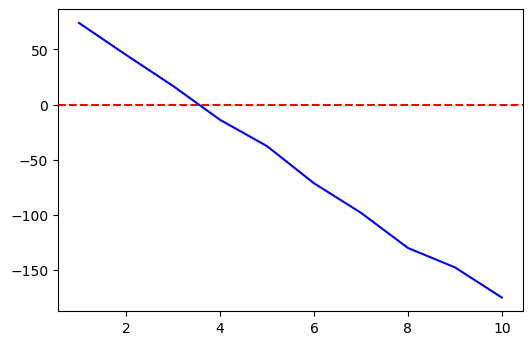

In [14]:
import matplotlib.pyplot as plt

def water_balance_in_canal(agent_results):
    index = []
    water_volume = []
    for i in range(agent_results.index.get_level_values(0).min(), agent_results.index.get_level_values(0).max()+1):
        results_current_step = agent_results.xs(i, level=0)
        index.append(i)
        water_volume.append(results_current_step['Withdrawn water (m³/year)'].sum())
    water_balance = [water_available - x for x in water_volume]
    
    fig, ax = plt.subplots(dpi=100)
    ax.axhline(0, linestyle='--', color='red')
    ax.plot(index, water_balance, color='blue')

water_balance_in_canal(agents_results)